# Reproducibility as a Service Data Analysis
This notebook analyzes the data collected by executing R scripts with and without the retroactive reproducibility tool RaaS.
All plots and tables displayed in the paper are generated here.

Imports
---------

In [1]:
import os
import sqlite3
import json
import requests
import re
import matplotlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from glob import glob

from helper_functions import *

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 25}
matplotlib.rc('font', **font)

%matplotlib inline

Analyzing scripts that ran __*without*__ RaaS
=======================================

These scripts executed in a rocker/tidyverse environment, R version 3.6.3, with a time limit of one script per hour, up to five hours per dataset.

We'll use three dataframes for this analysis, one at the granularity of scripts (`scripts_df`), one at the granularity of datasets (`dataset_df`), and a joined version (`overall_df`). 
Our first we'll process the raw data and generate these dataframes.

__Generate Scripts Dataframe__

In [2]:
con = sqlite3.connect("../data/results.db")

scripts_df = pd.read_sql_query("SELECT * FROM results", con) 
scripts_df["doi"] = get_doi_from_results_filename_v(scripts_df["filename"])
scripts_df["error_category"] = determine_error_cause_v(scripts_df["error"])

scripts_df = scripts_df[["filename", "error", "doi", "error_category"]]
scripts_df["unique_id"] = create_script_id_v(scripts_df["doi"].values, scripts_df["filename"].values)
scripts_df.columns = ['filename', 'nr_error', 'doi', 'nr_error_category', 'unique_id']

__Generate Datasets Dataframe__

In [3]:
# Load in metadata about each doi generated from get_doi_metadata.ipynb 
with open("../data/doi_metadata.json", "r") as doi_file:
    doi_metadata = json.loads(doi_file.read())

# Identify all subjects that R scripts were uploaded under on Dataverse
subject_set = set()
for doi_key in doi_metadata:
    if doi_metadata[doi_key][0] is not None:
        for subject in doi_metadata[doi_key][0]:
            subject_set.add(subject)   

In [4]:
# generate a dataset dataframe. Initialize and populate as a dict that we will later convert to a dataframe
df_dict = {"doi": [], "year":[]}
for subject in subject_set:
    df_dict[subject] = []

for doi_key in doi_metadata:
    if doi_metadata[doi_key][0] is not None:
        df_dict["year"].append(doi_metadata[doi_key][1])
        df_dict["doi"].append(doi_key.strip("\n"))
        for subject in subject_set:
            if subject in doi_metadata[doi_key][0]:
                df_dict[subject].append(True)
            else:
                df_dict[subject].append(False)

dataset_df = pd.DataFrame(df_dict)

In [5]:
# Add the time it took for each dataset to execute to the dataframe
no_raas_times = pd.read_csv("../data/dataset_times.csv")
dataset_df["nr_time"] = None
col_idx = dataset_df.columns.get_loc("nr_time")
for index, row in no_raas_times.iterrows():
    doi = get_doi_from_dir_path(row["doi"])
    row_idx = dataset_df[dataset_df["doi"] == doi].index
    dataset_df.iloc[row_idx, col_idx] = row["time"]

In [6]:
# Add a boolean column identifying whether or not a dataset was 'clean,' aka no scripts had errors
clean_col = []
for doi in dataset_df["doi"].values:
    clean_col.append(is_clean(doi, scripts_df))
dataset_df["nr_clean"] = clean_col
dataset_df["nr_timed_out"] = False
no_raas_timeouts_dois = []
with open("../data/no_raas_timeouts.txt", "r") as no_raas_timeouts_file:
    no_raas_timeouts_dois = strip_newlines_v(no_raas_timeouts_file.readlines())

nr_timeout_idxs = dataset_df[dataset_df["nr_time"] > 18000].index
dataset_df.loc[nr_timeout_idxs, "nr_timed_out"] = True
valid_datasets_df = dataset_df[dataset_df["nr_timed_out"] == False]

__Generate Overall Joined Dataframe__

In [7]:
overall_df = scripts_df.join(dataset_df.set_index("doi"), on="doi")

Comparison of Chen's 2018 Study to our 2022 Study
------------------------------------------------

__Comparison of Total Errors and Successes__

In [8]:
total_num_scripts = len(scripts_df[scripts_df["nr_error"] != "timed out"].index)
num_success_scripts = len(scripts_df[scripts_df["nr_error_category"] == "success"].index)
num_error_scripts = len(scripts_df[~scripts_df.nr_error_category.isin(["success", "timed out"])].index)

In [9]:
num_error_scripts

14573

In [10]:
chen_comparison_markdown = '''
------------------------------------------------
              Chen's              Ours 
  --------- -------- --------- ------- ---------
  Result       Count   Percent   Count   Percent

  Success        408     14.4%   OUR_SUCCESS_COUNT     OUR_SUCCESS_PERCENT%

  Error         2431     85.6%   OUR_ERROR_COUNT    OUR_ERROR_PERCENT%

  Total         2839             OUR_TOTAL 
------------------------------------------------


Table: The occurrences of errors in scripts from Dataverse without
processing through a reproducibility framework. The first set of
results are from Chen's study in 2018, and the second is ours
conducted in 2022. The percents are rounded to the nearest tenth. {#tbl:error-occurrences}
'''

chen_comparison_markdown = chen_comparison_markdown.replace("OUR_SUCCESS_COUNT", str(num_success_scripts))
chen_comparison_markdown = chen_comparison_markdown.replace("OUR_SUCCESS_PERCENT", "{0:.4g}".format(num_success_scripts / total_num_scripts * 100))

chen_comparison_markdown = chen_comparison_markdown.replace("OUR_ERROR_COUNT", str(num_error_scripts))
chen_comparison_markdown = chen_comparison_markdown.replace("OUR_ERROR_PERCENT", "{0:.4g}".format(num_error_scripts / total_num_scripts * 100))

chen_comparison_markdown = chen_comparison_markdown.replace("OUR_TOTAL", str(total_num_scripts))

write_file_from_string("chen_total_comparison.md", chen_comparison_markdown)

__Comparison of Error Categories__

In [11]:
category_comparison_md = '''
------------------------------------------------------------
                        containR              RaaS 
  ------------------- ---------- --------- ------- ---------
  Error Type               Count   Percent   Count   Percent

  Library                    363     14.9%    LIBRARY_COUNT    LIBRARY_PERCENT%

  Working directory          696     28.6%    WD_COUNT    WD_PERCENT%

  Missing file               802     33.0%    FILE_COUNT    FILE_PERCENT%

  Function                    NA        NA     FUNC_COUNT    FUNC_PERCENT%

  Other                      569     23.4%    OTHER_COUNT    OTHER_PERCENT%

  Total                     2431              ERROR_TOTAL 

------------------------------------------------------------

Table: The most common causes of errors in scripts from Dataverse without
processing through RaaS. The percents are rounded to the nearest
tenth. {#tbl:error-causes}
'''

def replace_in_table(key, category, markdown, scripts_df, total):
    error_count = len(scripts_df[scripts_df["nr_error_category"] == category].index)
    markdown = markdown.replace(key + "_COUNT", str(error_count))
    markdown = markdown.replace(key + "_PERCENT", "{0:.4g}".format(error_count / total * 100))
    return(markdown)

category_comparison_md = replace_in_table("LIBRARY", "library", category_comparison_md, scripts_df, num_error_scripts)
category_comparison_md = replace_in_table("WD", "working directory", category_comparison_md, scripts_df, num_error_scripts)
category_comparison_md = replace_in_table("FILE", "missing file", category_comparison_md, scripts_df, num_error_scripts)
category_comparison_md = replace_in_table("FUNC", "function", category_comparison_md, scripts_df, num_error_scripts)
category_comparison_md = replace_in_table("OTHER", "other", category_comparison_md, scripts_df, num_error_scripts)

category_comparison_md = category_comparison_md.replace("ERROR_TOTAL", str(num_error_scripts))

write_file_from_string("chen_category_comparison.md", category_comparison_md)

__Breakdown by Subject and Dataset__

In [12]:
subject_breakdown_md = '''
-------------------------------------------------------------------------------------
  Subject                                Total Files   Total Error Files   Error Rate
  ------------------------------------ ------------- ------------------- ------------
  Social Sciences                              Social Sciences_TOTAL               Social Sciences_ERROR       Social Sciences_PERC%

  Computer and Information Science               Computer and Information Science_TOTAL                 Computer and Information Science_ERROR       Computer and Information Science_PERC%

  Medicine, Health and Life Sciences             Medicine, Health and Life Sciences_TOTAL                 Medicine, Health and Life Sciences_ERROR       Medicine, Health and Life Sciences_PERC%

  Physics                                         Physics_TOTAL                  Physics_ERROR       Physics_PERC%

  Engineering                                    Engineering_TOTAL                  Engineering_ERROR       Engineering_PERC%

  Other                                          Other_TOTAL                 Other_ERROR       Other_PERC%

  Business and Management                        Business and Management_TOTAL                 Business and Management_ERROR        Business and Management_PERC%

  Mathematical Sciences                          Mathematical Sciences_TOTAL                 Mathematical Sciences_ERROR       Mathematical Sciences_PERC%

  Arts and Humanities                            Arts and Humanities_TOTAL                 Arts and Humanities_ERROR       Arts and Humanities_PERC%

  Agricultural Sciences                          Agricultural Sciences_TOTAL                 Agricultural Sciences_ERROR       Agricultural Sciences_PERC%

  Law                                            Law_TOTAL                 Law_ERROR       Law_PERC%

  Earth and Environmental Sciences               Earth and Environmental Sciences_TOTAL                 Earth and Environmental Sciences_ERROR       Earth and Environmental Sciences_PERC%


-------------------------------------------------------------------------------------

  Table: This table contains the breakdown of error occurrences in R scripts
  on Dataverse by subject. Percentages are rounded to the nearest tenth. {#tbl:subject-breakdown}
'''

def replace_in_subject_table(key, markdown, subject_script_df):
    total = len(subject_script_df.index)
    error_count = len(subject_script_df[subject_script_df["nr_error_category"] != "success"].index)
    markdown = markdown.replace(key + "_TOTAL", str(total))
    markdown = markdown.replace(key + "_ERROR", str(error_count))
    markdown = markdown.replace(key + "_PERC", "{0:.4g}".format(error_count / total * 100))
    return(markdown)

def get_subject_scripts(subject, dataset_df, scripts_df):
    dois_in_subject = dataset_df[dataset_df[subject] == True]["doi"].values
    scripts_from_doi = scripts_df[scripts_df.doi.isin(dois_in_subject)]
    return scripts_from_doi

for subject in subject_set:
    subject_script_df = get_subject_scripts(subject, valid_datasets_df[["doi", subject]], scripts_df)
    subject_breakdown_md = replace_in_subject_table(subject, subject_breakdown_md, subject_script_df)

write_file_from_string("subject_breakdown.md", subject_breakdown_md)

__Errors by Year Plot__

In [13]:
# Massage the data into the format used for plotting
years = set(dataset_df["year"].values)
year_breakdown = {"Year":[], "Total Files": [], "Total Error Files":[], "Error Rate (Rounded)":[]}
for year in years:
    scripts_in_year = overall_df[overall_df["year"] == year]
    total_files = len(scripts_in_year.index)
    if(total_files == 0):
        continue
        
    year_breakdown["Year"].append(str(year))
    total_error_files = len(scripts_in_year[scripts_in_year["nr_error_category"] != "success"].index)
    year_breakdown["Total Files"].append(total_files)
    year_breakdown["Total Error Files"].append(total_error_files)
    year_breakdown["Error Rate (Rounded)"].append("{0:.4g}".format(total_error_files / total_files * 100))
year_breakdown_df = pd.DataFrame(year_breakdown)
year_breakdown_df.sort_values(["Year"], inplace=True)

year_breakdown_df.columns = ["Year", "Total", "with Errors", "Error Rate"]
year_melted_df = year_breakdown_df[["Year", "with Errors", "Total"]]\
    .loc[year_breakdown_df['Year'].isin(["2015","2016", "2017", "2018", "2019", "2020", "2021",])]\
    .melt(id_vars='Year').rename(columns=str.title)
year_melted_df.columns = ["Year", "Count Type", "Count"]

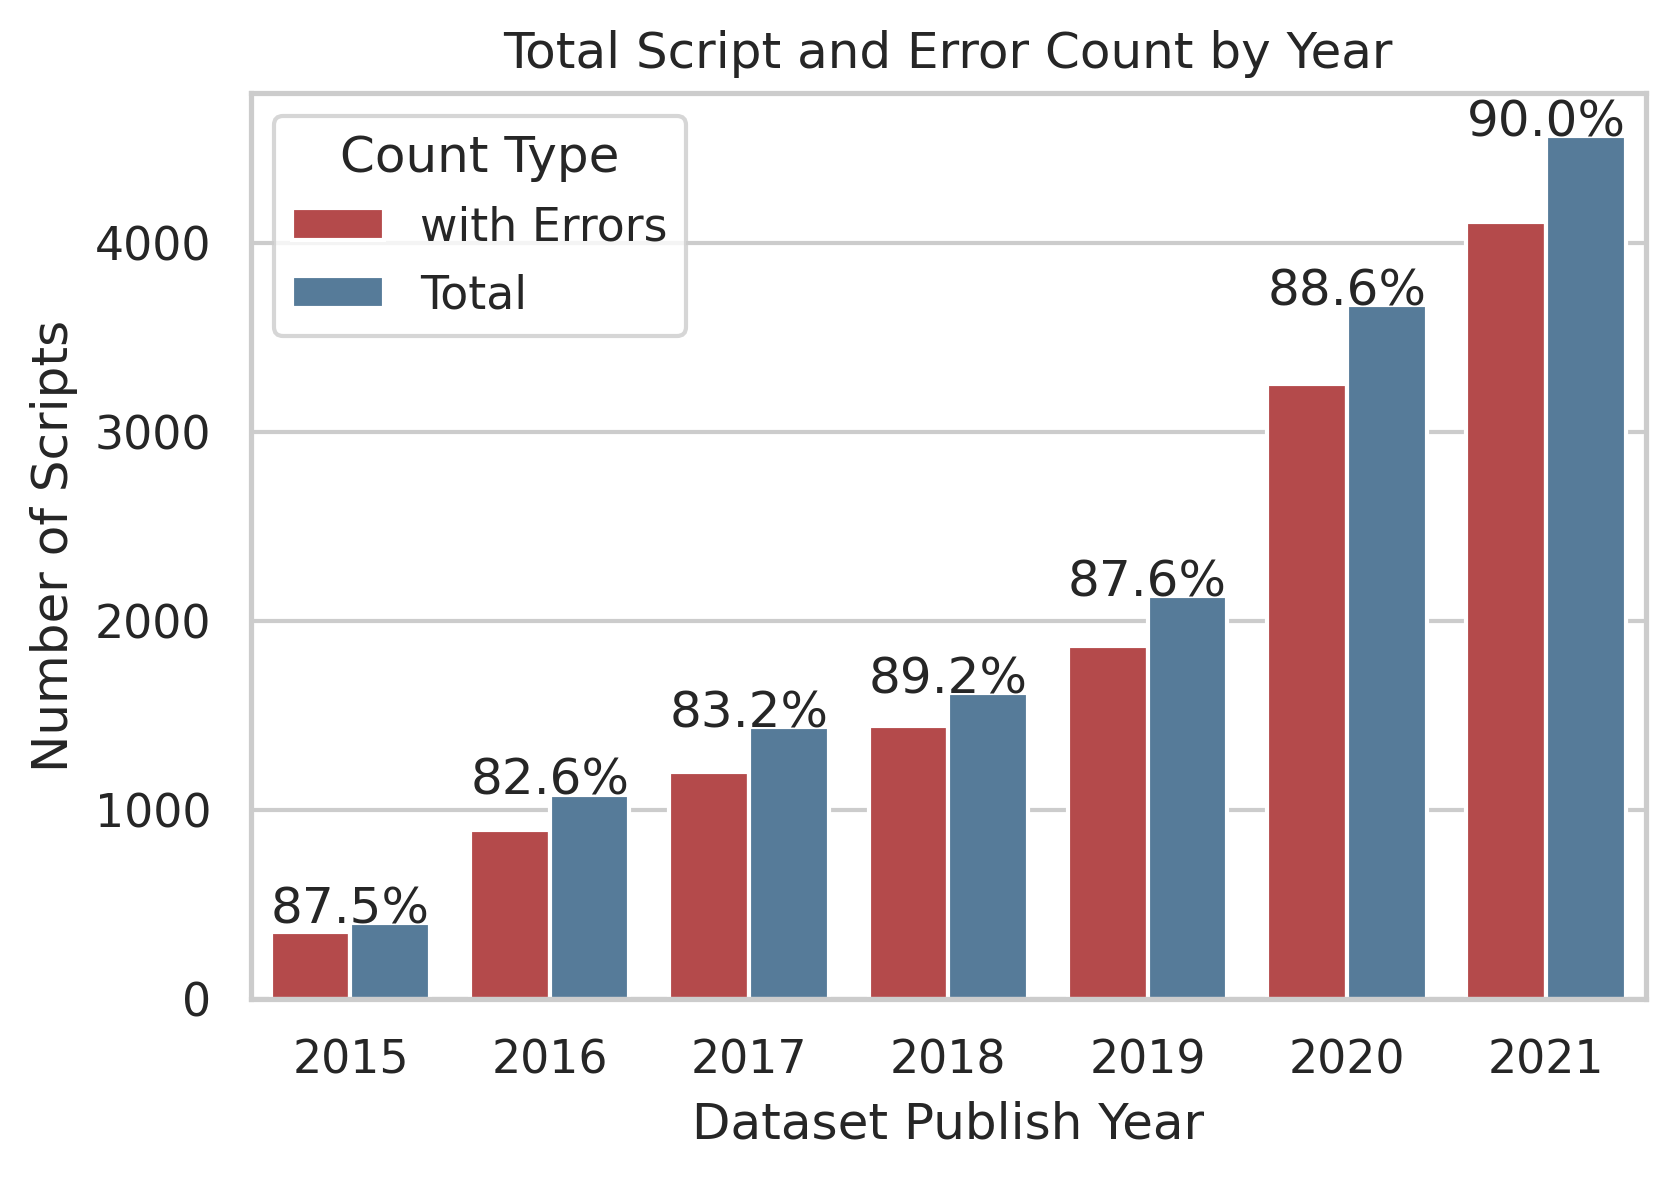

In [14]:
#plt.figure(figsize=(10, 5), dpi=300)
plt.figure(dpi=300)
sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.set_context("notebook")
ax = sns.barplot(x="Year", y="Count", hue="Count Type", data=year_melted_df, palette=sns.color_palette("Set1", n_colors=2, desat=.7))
ax.set_title('Total Script and Error Count by Year')
ax.set_xlabel("Dataset Publish Year")
ax.set_ylabel("Number of Scripts")
year_errors_df = year_melted_df[year_melted_df["Count Type"] == "with Errors"]
x_index = 0
for index, row in year_errors_df.iterrows():
    x = row["Year"]
    y = row["Count"]
    total = year_melted_df[year_melted_df["Count Type"] == "Total"]
    total = total[total["Year"] == row["Year"]]
    perc = round(row["Count"] / total["Count"].values[0] * 100, 1)
    ax.text(x=x_index,y=total["Count"].values[0],s=str(perc) + "%", ha="center")
    x_index += 1
#plt.show()
plt.savefig('../results/error_count_by_year.png', format="png")

__Errors by Subject Plot__

In [15]:
subjects = dataset_df.loc[:, ~dataset_df.columns.isin(['doi', 'year', 'nr_time', 'nr_clean'])].columns

subject_breakdown = {"Subject":[], "Total Files": [], "Total Error Files":[], "Error Rate (Rounded)":[]}
for subject in subjects:
    scripts_in_subject = overall_df[overall_df[subject] == True]
    total_files = len(scripts_in_subject.index)
    if(total_files == 0):
        continue
        
    subject_breakdown["Subject"].append(subject)
    total_error_files = len(scripts_in_subject[scripts_in_subject["nr_error_category"] != "success"].index)
    subject_breakdown["Total Files"].append(total_files)
    subject_breakdown["Total Error Files"].append(total_error_files)
    subject_breakdown["Error Rate (Rounded)"].append("{0:.4g}".format(total_error_files / total_files * 100))

subject_breakdown_df = pd.DataFrame(subject_breakdown)    
subject_breakdown_df['Subject'] = pd.Categorical(subject_breakdown_df['Subject'],categories=['Social Sciences',\
                                                           'Computer and Information Science',\
                                                           'Medicine, Health and Life Sciences',\
                                                           'Physics',\
                                                           'Engineering',\
                                                           'Other',\
                                                           'Business and Management',\
                                                           'Mathematical Sciences',\
                                                           'Arts and Humanities',\
                                                           'Agricultural Sciences',\
                                                           'Law',\
                                                           'Earth and Environmental Sciences'],ordered=True)
subject_breakdown_df = subject_breakdown_df.sort_values('Subject',ascending=True)
subject_breakdown_df = subject_breakdown_df[~subject_breakdown_df["Subject"].isna()]

subject_err_df = pd.DataFrame(columns=["Subject", "is_error"])

for _, row in subject_breakdown_df.iterrows():
    num_err = int(row["Total Error Files"])
    num_suc = int(row["Total Files"] - row["Total Error Files"])
    subject_err_df = subject_err_df.append(([pd.DataFrame({"Subject" : [row["Subject"]], "is_error": [0]})] * num_suc))
    subject_err_df = subject_err_df.append(([pd.DataFrame({"Subject" : [row["Subject"]], "is_error": [1]})] * num_err))

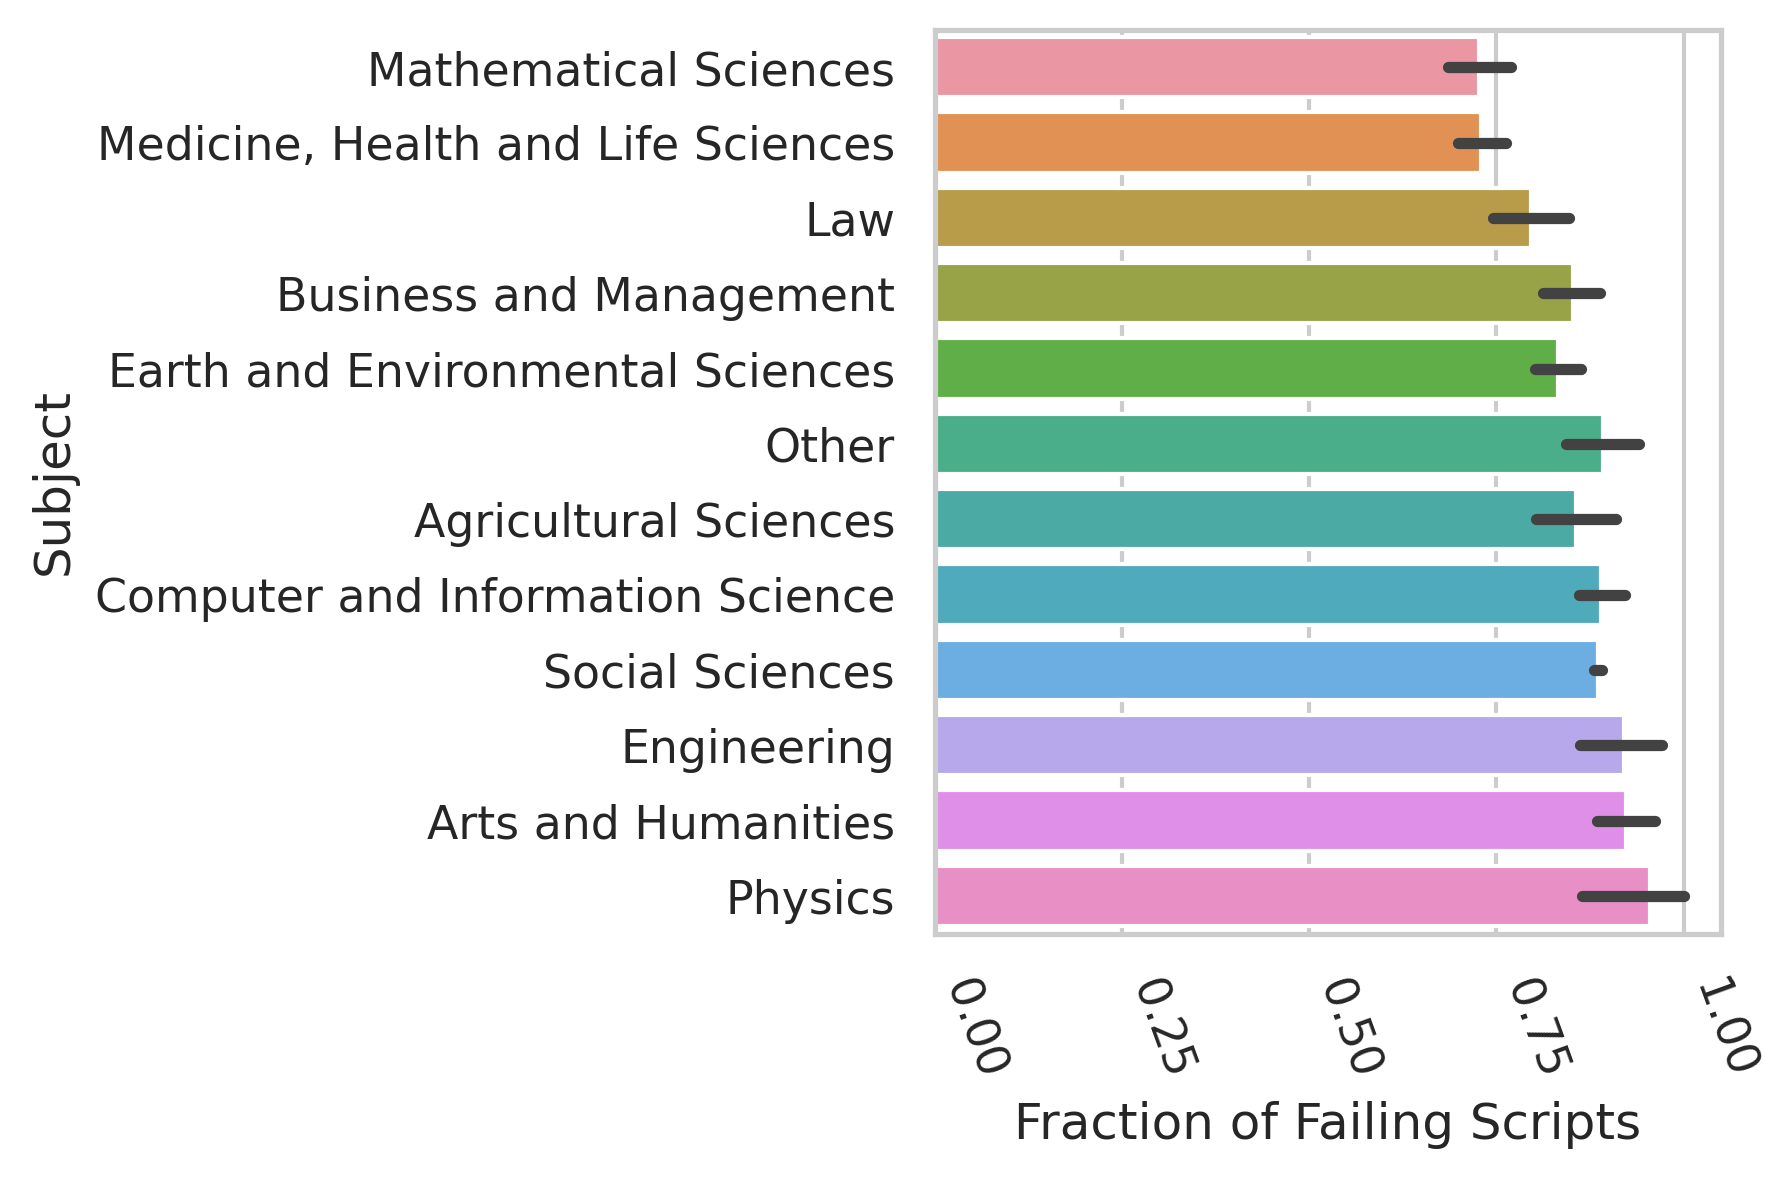

In [16]:
plt.figure(dpi=300)
plt.xticks(rotation=-70, ha = "left")
sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.set_context("notebook")
ax = sns.barplot(y=subject_err_df['Subject'], 
                 x=subject_err_df['is_error'],
                order=["Mathematical Sciences", 
                      "Medicine, Health and Life Sciences",
                      "Law",
                      "Business and Management",
                      "Earth and Environmental Sciences",
                      "Other",
                      "Agricultural Sciences",
                      "Computer and Information Science",
                      "Social Sciences",
                      "Engineering",
                      "Arts and Humanities",
                      "Physics"])
#ax.set_title('Script Failure Proportion by Subject')
ax.set_ylabel("Subject")
ax.set_xlabel("Fraction of Failing Scripts")
plt.tight_layout()
#plt.show()
plt.savefig('../results/error_rate_by_subject.png', format="png")

Analyzing scripts that ran __*with*__ RaaS
=======================================

These scripts executed in a rocker/tidyverse environment, R version 3.6.3, with a time limit of one script per hour, up to five hours per dataset AFTER RaaS processed them.

In [20]:
# Collect the path to all databases that contain data for datasets evaluated by RaaS
db_files = [y for x in os.walk("../data/raas_dbs") for y in glob(os.path.join(x[0], '*app.db'))]

# List of dataframes to concat later from each database
result_dfs = []

# Convert the dataset table written by RaaS to a dataframe for each database we have and then 
# concat into a single dataframe we will use in the eval
for db_file in db_files:
    con = sqlite3.connect(db_file)
    result_dfs.append(pd.read_sql_query("SELECT report FROM dataset", con))
        
# The final dataframe that contains all of the data from all devices that processed datasets with RaaS
raas_df = pd.concat(result_dfs)

def get_cleanliness_from_report(report):
    report_dict = json.loads(report)
    if len(report_dict["Individual Scripts"]) == 0:
        return None
    scripts_df = pd.DataFrame(report_dict["Individual Scripts"]).transpose()
    scripts_df["Errors"] = scripts_df["Errors"].apply(lambda x: x[0] if x else "success")
    error_set = set(scripts_df["Errors"].values)
    return(len(error_set) == 1 and "success" in error_set)
get_cleanliness_from_report_v = np.vectorize(get_cleanliness_from_report)

def get_nums_scripts_from_report(report):
    report_dict = json.loads(report)
    return len(report_dict["Individual Scripts"])
get_nums_scripts_from_report_v = np.vectorize(get_nums_scripts_from_report)

raas_df["doi"] = get_doi_from_report_v(raas_df["report"].values)
raas_df["raas_time"] = get_time_from_report_v(raas_df["report"].values)
raas_df["raas_clean"] = get_cleanliness_from_report_v(raas_df["report"].values)
raas_df["raas_num_scripts"] = get_nums_scripts_from_report_v(raas_df["report"].values)
raas_df["raas_timed_out"] = False

In [21]:
# Collect the path to all files that contain data for datasets timed out when running with RaaS
timeout_doi_file_list = [y for x in os.walk("../data/raas_timeouts") for y in glob(os.path.join(x[0], '*timeout-dois.txt'))]

timeout_dois = []
for timeout_file_path in timeout_doi_file_list:
    with open(timeout_file_path, "r") as timeout_file:
        timeout_dois = timeout_dois + timeout_file.readlines()
both_datasets_df = dataset_df.join(raas_df.set_index("doi"), on="doi") 
timed_out_col_idx = both_datasets_df.columns.get_loc("raas_timed_out")
timed_out_row_idxs = both_datasets_df[both_datasets_df.doi.isin(strip_newlines_v(timeout_dois))].index
both_datasets_df.loc[timed_out_row_idxs, "raas_timed_out"] = True

In [22]:
raas_scripts_dict = {"raas_error":[], "unique_id" : []}

def get_scripts_info_from_report(report):
    report_dict = json.loads(report)
    if len(report_dict["Individual Scripts"]) < 1:
        #print(report_dict["Additional Information"]["Container Name"])
        return ([], [])
    scripts_temp_df = pd.DataFrame(report_dict["Individual Scripts"]).transpose()
    timed_out_scripts = scripts_temp_df[scripts_temp_df["Timed Out"] == True]
    if(len(timed_out_scripts.index) > 0):
        print(timed_out_scripts)
    #timed_out_idxs = scripts_temp_df
    return(scripts_temp_df.index.values, scripts_temp_df.Errors.values)

for _, row in raas_df.iterrows():
    filenames, errors = get_scripts_info_from_report(row["report"])
    if len(filenames) == len(errors) and len(filenames) != 0:
        raas_scripts_dict["raas_error"] = raas_scripts_dict["raas_error"] + [error if error != [] else "success" for error in errors]
        raas_scripts_dict["unique_id"] = raas_scripts_dict["unique_id"] + list(create_script_id_v([row["doi"]] * len(filenames), filenames))
        #raas_scripts_dict["doi"] = raas_scripts_dict["doi"] + [row["doi"]] * len(filenames)
    else:
        print(row["doi"])
    #print(filenames)
    
#[error for error in raas_scripts_dict["error"] if error is not None and len(error) >1]
raas_scripts_dict["raas_error"] = [error[0] if error != "success" else error for error in raas_scripts_dict["raas_error"]]
raas_scripts_df = pd.DataFrame(raas_scripts_dict)
raas_scripts_df["raas_error_category"] = determine_error_cause_v(raas_scripts_df["raas_error"])

doi:10.7910/DVN/RT5JTV
doi:10.7910/DVN/GX6AEU
doi:10.7910/DVN/TFXQJN


In [23]:
both_scripts_df = scripts_df.merge(raas_scripts_df.set_index("unique_id"), on="unique_id")
both_scripts_df[both_scripts_df.raas_error.notna()]

both_scripts_df

,filename,nr_error,doi,nr_error_category,unique_id,raas_error,raas_error_category
0,/home/rstudio/doi-10.7910-DVN-MB2UKU/./analysi...,success,doi:10.7910/DVN/MB2UKU,success,doi:10.7910/DVN/MB2UKU:analysis_afd_voting_pre...,success,success
1,/home/rstudio/doi-10.7910-DVN-MB2UKU/./analysi...,success,doi:10.7910/DVN/MB2UKU,success,doi:10.7910/DVN/MB2UKU:analysis_biw_voting_pre...,success,success
2,/home/rstudio/doi-10.7910-DVN-MB2UKU/./analysi...,success,doi:10.7910/DVN/MB2UKU,success,doi:10.7910/DVN/MB2UKU:analysis_survey_ri.r,success,success
3,/home/rstudio/doi-10.7910-DVN-MB2UKU/./analysi...,success,doi:10.7910/DVN/MB2UKU,success,doi:10.7910/DVN/MB2UKU:analysis_warning_signs_...,success,success
4,/home/rstudio/doi-10.7910-DVN-JWL4PK/./bim_plot.R,Error : RStudio not running,doi:10.7910/DVN/JWL4PK,other,doi:10.7910/DVN/JWL4PK:bim_plot.r,success,success
...,...,...,...,...,...,...,...
8727,/home/rstudio/doi-10.7910-DVN-F6CVMG/./DGMRP-R...,Error in library(dgo) : there is no package ca...,doi:10.7910/DVN/F6CVMG,library,doi:10.7910/DVN/F6CVMG:dgmrp-replication.r,success,success
8728,/home/rstudio/doi-10.7910-DVN-ROUWNS/./Rep_Fig1.R,"Error in pdf(file = ""C:/Users/Peter/Dropbox/dr...",doi:10.7910/DVN/ROUWNS,other,doi:10.7910/DVN/ROUWNS:rep_fig1.r,"Error in read.dta(""results.dta"", convert.facto...",missing file
8729,/home/rstudio/doi-10.7910-DVN-ROUWNS/./Rep_Fig...,Error in library(readstata13) : there is no pa...,doi:10.7910/DVN/ROUWNS,library,doi:10.7910/DVN/ROUWNS:rep_figh1.r,success,success
8730,/home/rstudio/doi-10.7910-DVN-CMVB4Q/./Graphics.R,success,doi:10.7910/DVN/CMVB4Q,success,doi:10.7910/DVN/CMVB4Q:graphics.r,success,success


In [53]:
timed_out_md = '''
-------------------------------------------------------------------------
    Datasets                                                      Scripts
  ---------- ------------- ------------ ---------------- ----------------
       Total   TO w/o RaaS   TO w/ RaaS   Both Completed   Both Completed

        TOTAL_DS             DS_TO_WO_RAAS_TOTAL           DS_TO_W_RAAS_TOTAL             DS_BOTH_DONE_TOTAL             SC_BOTH_DONE_TOTAL

        100%      DS_TO_WO_RAAS_PERC%      DS_TO_W_RAAS_PERC%           DS_BOTH_DONE_PERC%          SC_BOTH_DONE_PERC%\*

-------------------------------------------------------------------------

Table: This table displays the number of datasets that time out (TO) during
the evaluations, and the number that completed with and without RaaS.
\*Note that for the number of scripts that completed in both, the
percentage is out of the total number of scripts: 11819. The rest of
the percentages are out of the total number of datasets: 2900. {#tbl:timeout-results}
'''
def replace_timed_out_table(timed_out_md, total, percent, key):
    timed_out_md = timed_out_md.replace(key + "_TOTAL", str(total))
    timed_out_md = timed_out_md.replace(key + "_PERC", str(percent))
    return(timed_out_md)


total_datasets = len(both_datasets_df.index)
num_datasets_without_raas_timed_out = len(both_datasets_df[both_datasets_df["nr_timed_out"] == True].index)
num_datasets_with_raas_timed_out = len(both_datasets_df[both_datasets_df["raas_timed_out"] == True].index)
num_datasets_both_completed = len(both_datasets_df[(both_datasets_df["raas_timed_out"] == False) & (both_datasets_df["nr_timed_out"] == False)].index)

timed_out_md = timed_out_md.replace("TOTAL_DS", str(total_datasets))
timed_out_md = replace_timed_out_table(timed_out_md, num_datasets_without_raas_timed_out, "{0:.4g}".format(num_datasets_without_raas_timed_out / total_datasets * 100), "DS_TO_WO_RAAS")
timed_out_md = replace_timed_out_table(timed_out_md, num_datasets_with_raas_timed_out, "{0:.4g}".format(num_datasets_with_raas_timed_out / total_datasets * 100), "DS_TO_W_RAAS")
timed_out_md = replace_timed_out_table(timed_out_md, num_datasets_both_completed, "{0:.4g}".format(num_datasets_both_completed / total_datasets * 100), "DS_BOTH_DONE")

write_file_from_string("timed_out_comparisons.md", timed_out_md)

In [26]:
both_datasets_df[both_datasets_df["raas_timed_out"] == True]

,doi,year,Social Sciences,"Medicine, Health and Life Sciences",Computer and Information Science,Engineering,Chemistry,Law,Earth and Environmental Sciences,Business and Management,...,Arts and Humanities,Agricultural Sciences,nr_time,nr_clean,nr_timed_out,report,raas_time,raas_clean,raas_num_scripts,raas_timed_out
59,doi:10.7910/DVN/LF2Q8P,2020,True,False,False,False,False,False,False,False,...,False,False,2.88573,False,False,NaN,NaN,NaN,NaN,True
102,doi:10.7910/DVN/GCZG82,2021,True,False,False,False,False,False,False,False,...,False,False,46.947914,False,False,NaN,NaN,NaN,NaN,True
222,doi:10.7910/DVN/XRJ43D,2017,True,False,False,False,False,False,False,False,...,False,False,346.024517,False,False,NaN,NaN,NaN,NaN,True
634,doi:10.7910/DVN/PAHRCK,2019,True,False,False,False,False,False,False,False,...,False,False,14.508523,False,False,NaN,NaN,NaN,NaN,True
847,doi:10.7910/DVN/IUXG2I,2019,True,False,False,False,False,False,False,False,...,False,False,3581.228782,True,False,NaN,NaN,NaN,NaN,True
1122,doi:10.7910/DVN/9RTI0V,2015,True,False,False,False,False,False,False,False,...,False,False,460.59078,False,False,NaN,NaN,NaN,NaN,True
1956,doi:10.7910/DVN/PHHZI7,2017,True,False,False,False,False,False,False,False,...,False,False,24.218732,False,False,NaN,NaN,NaN,NaN,True
1961,doi:10.7910/DVN/D5DEHM,2017,True,False,False,False,False,False,False,False,...,False,False,32.498753,False,False,NaN,NaN,NaN,NaN,True
2281,doi:10.7910/DVN/EF7R0Z,2021,True,False,False,False,False,False,False,False,...,False,False,100.925427,False,False,NaN,NaN,NaN,NaN,True
2471,doi:10.7910/DVN/T9WESH,2017,True,False,False,False,False,False,False,False,...,False,False,31.214089,False,False,NaN,NaN,NaN,NaN,True


,doi,year,Social Sciences,"Medicine, Health and Life Sciences",Computer and Information Science,Engineering,Chemistry,Law,Earth and Environmental Sciences,Business and Management,...,Arts and Humanities,Agricultural Sciences,nr_time,nr_clean,nr_timed_out,report,raas_time,raas_clean,raas_num_scripts,raas_timed_out
0,doi:10.7910/DVN/JWL4PK,2020,False,False,False,False,False,False,True,False,...,False,False,8.060398,False,False,"{""Container Information"": {""Language Packages""...",1666.121590,False,3.0,False
1,doi:10.7910/DVN/MB2UKU,2019,True,False,False,False,False,False,False,False,...,False,False,273.684908,True,False,"{""Container Information"": {""Language Packages""...",637.610661,True,4.0,False
2,doi:10.7910/DVN/WQRZHS,2019,True,False,False,False,False,False,False,False,...,False,False,9.492422,False,False,"{""Container Information"": {""Language Packages""...",2786.431906,False,1.0,False
3,doi:10.7910/DVN/DCTH7N,2021,True,False,False,False,False,False,False,False,...,False,False,6.087039,False,False,"{""Container Information"": {""Language Packages""...",84.450955,True,1.0,False
6,doi:10.7910/DVN/S9MIJU,2016,True,False,False,False,False,False,False,False,...,False,False,1.993516,False,False,"{""Container Information"": {""Language Packages""...",755.655228,True,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3817,doi:10.7910/DVN/PPVW17,2019,True,False,False,False,False,False,False,False,...,False,False,25.113687,False,False,"{""Container Information"": {""Language Packages""...",2778.705801,False,4.0,False
3818,doi:10.7910/DVN/F6CVMG,2020,True,False,False,False,False,False,False,False,...,False,False,25.591689,False,False,"{""Container Information"": {""Language Packages""...",3237.896150,True,1.0,False
3819,doi:10.7910/DVN/ROUWNS,2018,True,False,False,False,False,False,False,False,...,False,False,26.074828,False,False,"{""Container Information"": {""Language Packages""...",335.312757,False,2.0,False
3820,doi:10.7910/DVN/CMVB4Q,2020,True,False,False,False,False,False,False,False,...,False,False,23.367172,True,False,"{""Container Information"": {""Language Packages""...",80.147330,True,1.0,False


In [41]:
both_datasets_df

,doi,year,Social Sciences,"Medicine, Health and Life Sciences",Computer and Information Science,Engineering,Chemistry,Law,Earth and Environmental Sciences,Business and Management,...,Arts and Humanities,Agricultural Sciences,nr_time,nr_clean,nr_timed_out,report,raas_time,raas_clean,raas_num_scripts,raas_timed_out
0,doi:10.7910/DVN/JWL4PK,2020,False,False,False,False,False,False,True,False,...,False,False,8.060398,False,False,"{""Container Information"": {""Language Packages""...",1666.121590,False,3.0,False
1,doi:10.7910/DVN/MB2UKU,2019,True,False,False,False,False,False,False,False,...,False,False,273.684908,True,False,"{""Container Information"": {""Language Packages""...",637.610661,True,4.0,False
2,doi:10.7910/DVN/WQRZHS,2019,True,False,False,False,False,False,False,False,...,False,False,9.492422,False,False,"{""Container Information"": {""Language Packages""...",2786.431906,False,1.0,False
3,doi:10.7910/DVN/DCTH7N,2021,True,False,False,False,False,False,False,False,...,False,False,6.087039,False,False,"{""Container Information"": {""Language Packages""...",84.450955,True,1.0,False
4,doi:10.7910/DVN/NYS9UR,2022,True,False,False,False,False,False,False,False,...,False,False,2.475289,False,False,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3884,doi:10.7910/DVN/RTAJ0X,2021,True,False,False,False,False,False,False,False,...,False,False,None,None,False,NaN,NaN,NaN,NaN,NaN
3885,doi:10.7910/DVN/WKPTWB,2021,True,False,False,False,False,False,False,False,...,False,False,25.556535,False,False,NaN,NaN,NaN,NaN,NaN
3886,doi:10.7910/DVN/Y5Y6VD,2020,True,False,False,False,False,False,False,False,...,False,False,None,None,False,NaN,NaN,NaN,NaN,NaN
3887,doi:10.7910/DVN/D3OC1H,2020,True,False,False,False,False,False,False,False,...,False,False,None,None,False,NaN,NaN,NaN,NaN,NaN
